## Package preparation

In [1]:
import os
import time

import numpy as np
import pandas as pd
from sklearn.utils import shuffle, resample
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.contrib import rnn

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

print("Package is ready.")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Package is ready.


In [2]:
matplotlib.rcParams['figure.figsize'] = ((8/2.54)*2, (6/2.54)*2)
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 12})
MARKER_SIZE = 2
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

In [3]:
TIME_STEPS = 168
OUTPUT_SIZE = 1 # One point of ion
N_FOLD = 5
N_TASKS = 6 # K, Ca, Mg, S, N, P

INTERVAL = "1h"

EX_PRED = 0
EXPLANATION_ = "Ion_open_MT_LN" + "_I" + INTERVAL + "_T" + str(TIME_STEPS)
print(EXPLANATION_)

Ion_open_MT_LN_I1h_T168


## Data preparation

In [4]:
ion_label = pd.read_excel("../data/SW_Ion/Ion concentration_meq_20171109-20180426.xlsx", skiprows=1, index_col="date")

In [5]:
ion_label = ion_label[~(ion_label.index < '2018-01-12')]
#ion_label.drop(["N.1"], axis=1, inplace=True)
ion_label.drop(["K", "Ca", "Mg", "S", "N", "P"], axis=1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if "Unnamed:" in columns], axis= 1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if ".2" in columns], axis= 1, inplace=True)
ion_label.drop([columns for columns in ion_label.columns if ".3" in columns], axis= 1, inplace=True)
ion_label.dropna(inplace=True)
#ion_label.drop([pd.Timestamp("2018-04-23"), pd.Timestamp("2018-04-12"), pd.Timestamp("2018-04-05")], axis=0, inplace=True)
ion_label.drop([pd.Timestamp("2018-04-13")], axis=0, inplace=True)

In [6]:
ion_label.index += pd.Timedelta("16h")

In [7]:
ion_label = ion_label.sample(frac=1.0)

In [8]:
raw_open = pd.read_csv("./results/open_data.csv", index_col="TIMESTAMP")
raw_open.index = pd.DatetimeIndex(raw_open.index)
raw_open = raw_open[np.abs(raw_open-raw_open.mean())<=(3*raw_open.std())]
raw_open["RootTemp(2)"][0] = 20
raw_open.drop(["ECS(4)", "InjDrgVR(4)", "DrgDaily(4)", "DrgV(4)"], axis=1, inplace=True)
#raw_open.drop(["MixTnkpH(4)", "RWEC(4)", "InjDrgVR(4)", "DrgDaily(4)"], axis=1, inplace=True)

In [9]:
raw_open.interpolate("linear", inplace=True)

# raw_open.index = (raw_open.index).round(INTERVAL)
# raw_open = raw_open.groupby(raw_open.index).mean()

In [10]:
MAXS = raw_open.max()
MINS = raw_open.min()
LABELMAXS = ion_label.max()
LABELMINS = ion_label.min()

In [11]:
raw_open = (raw_open - MINS) / (MAXS - MINS)
ion_label = (ion_label - LABELMINS) / (LABELMAXS - LABELMINS)

In [12]:
env_input = []
for index in ion_label.index:
    last_time = index
    first_time = last_time - pd.Timedelta(INTERVAL)*(TIME_STEPS-1)
    
    TRAIN_RANGE = pd.date_range(first_time, last_time, freq=INTERVAL)
    env_input.append(raw_open.loc[TRAIN_RANGE])

In [13]:
for i in range(len(env_input)):
    env_input[i] = env_input[i].values
    
env_input = np.array(env_input)

In [14]:
env_input.shape

(52, 168, 23)

In [15]:
print(np.isnan(ion_label.values).any())
print(np.isnan(env_input).any())

False
False


In [16]:
rnn_inputs = []
rnn_labels = []
pred_inputs = []
pred_labels = []

N_TEST = int(ion_label.shape[0]/N_FOLD)

for i in range(N_FOLD-1):
    pred_inputs.append(env_input[i*N_TEST:(i+1)*N_TEST, :, :])
    pred_labels.append(ion_label.iloc[i*N_TEST:(i+1)*N_TEST, :])
    
    rnn_inputs.append(np.delete(env_input, np.arange(i*N_TEST, (i+1)*N_TEST), 0))
    rnn_labels.append(ion_label.drop(ion_label.index[np.arange(i*N_TEST, (i+1)*N_TEST)], axis=0))



pred_inputs.append(env_input[(N_FOLD-1)*N_TEST:, :, :])
pred_labels.append(ion_label.iloc[(N_FOLD-1)*N_TEST:, :])

rnn_inputs.append(env_input[:(N_FOLD-1)*N_TEST:, :, :])
rnn_labels.append(ion_label.iloc[:(N_FOLD-1)*N_TEST:, :])

In [17]:
for i in range(N_FOLD):
    print(np.isnan(pred_inputs[i]).any(), end=" ")
    print(np.isnan(pred_labels[i].values).any())
print()
for i in range(N_FOLD):
    print(np.isnan(rnn_inputs[i]).any(), end=" ")
    print(np.isnan(rnn_labels[i].values).any())

False False
False False
False False
False False
False False

False False
False False
False False
False False
False False


In [18]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

## Network

In [19]:
def FC(x, size, scope):
    return tf.contrib.layers.fully_connected(x, size, activation_fn=None, scope=scope)

def BN_FC(x, n_hidden, phase, scope):
    with tf.variable_scope(scope):
        h1 = tf.contrib.layers.fully_connected(x, n_hidden, activation_fn=None, scope='FC')
        h2 = tf.layers.batch_normalization(h1, training=phase)
        return tf.nn.relu(h2, 'relu')

1 fold start.
Epoch:        0/   50000 cost: 5.475759, best: 0.000
Training Acc: -19.361, Test Acc: -22.146
-113.774 -22.121 -0.228 -3.836 -13.656 -107.047 
-43.44376757121552
Epoch:      500/   50000 cost: 0.040022, best: 0.000
Training Acc: 0.710, Test Acc: -1.362
-3.628 -2.065 -6.905 -2.777 -0.918 -12.468 
-4.793439008720667
Epoch:     1000/   50000 cost: 0.007608, best: 0.000
Training Acc: 0.850, Test Acc: -0.677
-2.385 -1.354 -2.255 -3.039 0.059 -10.042 
-3.1694011060416085
Epoch:     1006/   50000 cost: 0.042208, best: 0.267 *Best value was replaced.
-2.385 -1.354 -2.255 -3.039 0.059 -10.042 
-3.1694011060416085
Epoch:     1007/   50000 cost: 0.023769, best: 0.402 *Best value was replaced.
-2.385 -1.354 -2.255 -3.039 0.059 -10.042 
-3.1694011060416085
Epoch:     1008/   50000 cost: 0.021218, best: 0.499 *Best value was replaced.
-2.385 -1.354 -2.255 -3.039 0.059 -10.042 
-3.1694011060416085
Epoch:     1216/   50000 cost: 0.023516, best: 0.514 *Best value was replaced.
-2.385 -1.3

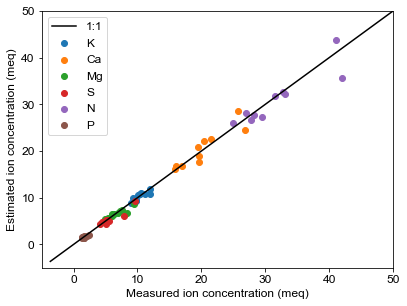

6 fold ended.
2 fold start.
Epoch:        0/   50000 cost: 7.801688, best: 0.000
Training Acc: -9.080, Test Acc: -14.167
-1.687 -0.999 0.080 -84.575 -15.527 -2.166 
-17.47908648646033
Epoch:      500/   50000 cost: 0.044239, best: 0.000
Training Acc: 0.479, Test Acc: 0.235
0.057 -0.155 0.431 0.367 0.275 0.246 
0.20355997508638332
Epoch:     1000/   50000 cost: 0.022001, best: 0.000
Training Acc: 0.241, Test Acc: -1.355
-0.227 0.681 -4.236 -4.899 0.580 -2.059 
-1.6933351163089811
Epoch:     1099/   50000 cost: 0.029856, best: 0.005 *Best value was replaced.
-0.227 0.681 -4.236 -4.899 0.580 -2.059 
-1.6933351163089811
Epoch:     1100/   50000 cost: 0.029152, best: 0.010 *Best value was replaced.
-0.227 0.681 -4.236 -4.899 0.580 -2.059 
-1.6933351163089811
Epoch:     1134/   50000 cost: 0.031193, best: 0.010 *Best value was replaced.
-0.227 0.681 -4.236 -4.899 0.580 -2.059 
-1.6933351163089811
Epoch:     1135/   50000 cost: 0.028341, best: 0.089 *Best value was replaced.
-0.227 0.681 -4.2


Early stopping.
Epoch:    10065/   50000 cost: 0.008567, best: 0.742
Training Acc: -0.023, Test Acc: 0.054
Optimization Finished
training time: 2845.23 sec.
INFO:tensorflow:Restoring parameters from ./models/best_trained_Ion_open_MT_LN_I1h_T168_F2.ckpt
Test accuracy: 0.7418224


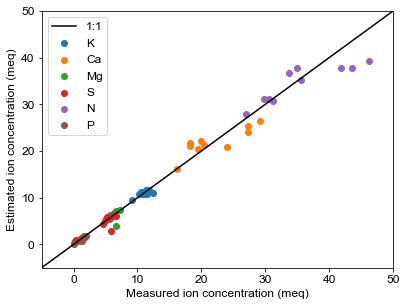

6 fold ended.
3 fold start.
Epoch:        0/   50000 cost: 7.670574, best: 0.000
Training Acc: -66.552, Test Acc: -29.027
0.059 -6.530 -7.707 -141.108 -13.466 -38.728 
-34.579966148482676
Epoch:      500/   50000 cost: 0.040148, best: 0.000
Training Acc: -0.101, Test Acc: 0.203
0.150 0.069 0.243 0.132 0.326 -0.254 
0.11107339706270726
Epoch:     1000/   50000 cost: 0.027163, best: 0.000
Training Acc: 0.505, Test Acc: 0.651
0.528 0.493 0.603 0.661 0.705 0.721 
0.6186482043374887
Epoch:     1002/   50000 cost: 0.032783, best: 0.704 *Best value was replaced.
0.528 0.493 0.603 0.661 0.705 0.721 
0.6186482043374887
Epoch:     1157/   50000 cost: 0.022277, best: 0.709 *Best value was replaced.
0.528 0.493 0.603 0.661 0.705 0.721 
0.6186482043374887
Epoch:     1158/   50000 cost: 0.023593, best: 0.713 *Best value was replaced.
0.528 0.493 0.603 0.661 0.705 0.721 
0.6186482043374887
Epoch:     1500/   50000 cost: 0.021092, best: 0.713
Training Acc: 0.918, Test Acc: 0.615
0.565 0.407 0.678 0.61

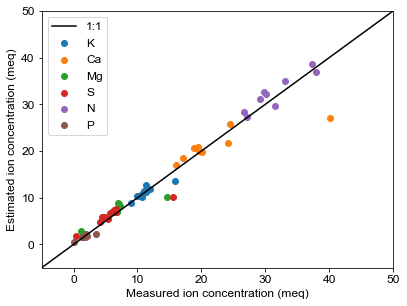

6 fold ended.
4 fold start.
Epoch:        0/   50000 cost: 4.495918, best: 0.000
Training Acc: -34.060, Test Acc: -52.514
-54.265 -341.190 -0.243 -6.876 -101.708 -0.821 
-84.18374058058966
Epoch:      500/   50000 cost: 0.048783, best: 0.000
Training Acc: -0.163, Test Acc: -1.515
-4.436 -1.335 -1.665 -1.139 -3.277 -0.819 
-2.1118686207635275
Epoch:     1000/   50000 cost: 0.013350, best: 0.000
Training Acc: 0.913, Test Acc: -0.315
-1.076 -0.338 -0.334 -0.904 -0.585 -0.058 
-0.5491830236695856
Epoch:     1146/   50000 cost: 0.014981, best: 0.020 *Best value was replaced.
-1.076 -0.338 -0.334 -0.904 -0.585 -0.058 
-0.5491830236695856
Epoch:     1147/   50000 cost: 0.038313, best: 0.056 *Best value was replaced.
-1.076 -0.338 -0.334 -0.904 -0.585 -0.058 
-0.5491830236695856
Epoch:     1148/   50000 cost: 0.017746, best: 0.077 *Best value was replaced.
-1.076 -0.338 -0.334 -0.904 -0.585 -0.058 
-0.5491830236695856
Epoch:     1149/   50000 cost: 0.012561, best: 0.098 *Best value was replace

Epoch:    13617/   50000 cost: 0.006681, best: 0.626 *Best value was replaced.
-0.413 -0.180 0.808 0.591 0.323 0.872 
0.333587710048433
Epoch:    14000/   50000 cost: 0.009211, best: 0.626
Training Acc: 0.731, Test Acc: -0.112
-0.950 -0.437 -0.545 0.057 -0.401 0.288 
-0.33109920240041574
Epoch:    14500/   50000 cost: 0.006343, best: 0.626
Training Acc: 0.039, Test Acc: -0.812
-2.589 -1.605 -1.513 -1.958 -0.617 0.687 
-1.2657758724596413
Epoch:    15000/   50000 cost: 0.010547, best: 0.626
Training Acc: 0.624, Test Acc: -0.070
-1.477 -0.913 0.231 -0.176 -1.058 0.635 
-0.45963090624240976
Epoch:    15500/   50000 cost: 0.008790, best: 0.626
Training Acc: 0.795, Test Acc: 0.071
-0.549 -0.765 -0.159 0.452 -1.220 0.755 
-0.24748121731860898
Epoch:    16000/   50000 cost: 0.006634, best: 0.626
Training Acc: 0.804, Test Acc: 0.259
-0.795 -0.116 0.558 0.416 -0.757 0.610 
-0.014039374824509954
Epoch:    16500/   50000 cost: 0.014470, best: 0.626
Training Acc: 0.470, Test Acc: 0.626
-0.077 0.40

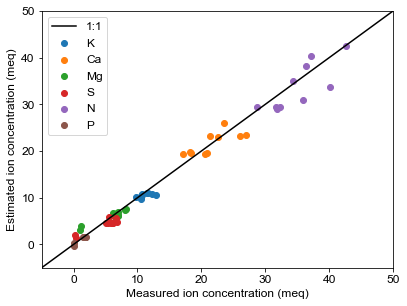

6 fold ended.
5 fold start.
Epoch:        0/   50000 cost: 6.163584, best: 0.000
Training Acc: -4.794, Test Acc: -6.184
-24.812 -7.104 -0.156 -10.197 -12.525 -2.959 
-9.625573290308187
Epoch:      500/   50000 cost: 0.086721, best: 0.000
Training Acc: 0.183, Test Acc: -0.315
-3.478 -2.598 -0.203 -0.094 0.298 0.190 
-0.980826310545508
Epoch:     1000/   50000 cost: 0.035715, best: 0.000
Training Acc: 0.177, Test Acc: -0.413
-0.458 0.111 0.237 -0.020 0.166 -1.795 
-0.29308690607483323
Epoch:     1016/   50000 cost: 0.029917, best: 0.068 *Best value was replaced.
-0.458 0.111 0.237 -0.020 0.166 -1.795 
-0.29308690607483323
Epoch:     1017/   50000 cost: 0.029529, best: 0.152 *Best value was replaced.
-0.458 0.111 0.237 -0.020 0.166 -1.795 
-0.29308690607483323
Epoch:     1018/   50000 cost: 0.057531, best: 0.205 *Best value was replaced.
-0.458 0.111 0.237 -0.020 0.166 -1.795 
-0.29308690607483323
Epoch:     1019/   50000 cost: 0.020960, best: 0.254 *Best value was replaced.
-0.458 0.111 

Epoch:     9500/   50000 cost: 0.043642, best: 0.885
Training Acc: 0.508, Test Acc: 0.715
0.119 0.420 0.711 0.813 0.550 0.883 
0.5827471165175001
Epoch:    10000/   50000 cost: 0.015956, best: 0.885
Training Acc: 0.842, Test Acc: 0.802
0.553 0.577 0.909 0.670 0.633 0.931 
0.7122230212308622
Epoch:    10500/   50000 cost: 0.013932, best: 0.885
Training Acc: 0.812, Test Acc: 0.766
-0.129 0.531 0.859 0.894 0.536 0.942 
0.6056281773393354
Epoch:    11000/   50000 cost: 0.009918, best: 0.885
Training Acc: 0.464, Test Acc: 0.447
-1.074 -0.478 0.671 0.877 0.222 0.615 
0.13877112594375413
Epoch:    11500/   50000 cost: 0.013603, best: 0.885
Training Acc: 0.825, Test Acc: 0.862
0.446 0.587 0.982 0.955 0.720 0.924 
0.7687642915945957
Epoch:    12000/   50000 cost: 0.009727, best: 0.885
Training Acc: 0.555, Test Acc: 0.721
-0.377 0.460 0.902 0.921 0.333 0.912 
0.5250251001210177
Epoch:    12500/   50000 cost: 0.006918, best: 0.885
Training Acc: 0.569, Test Acc: 0.781
0.187 0.428 0.878 0.956 0.468

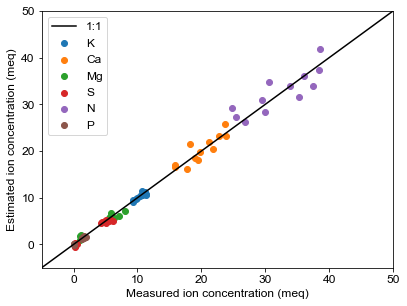

6 fold ended.
All fold vaildation were ended.
5-fold validation accuracy: 0.775


In [20]:
accuracies = []
for i in range(N_FOLD):
    print("%d fold start." % (i+1))

    pred_input = pred_inputs[i]
    pred_label = pred_labels[i]
    
    rnn_input = rnn_inputs[i]
    rnn_label = rnn_labels[i]
    
    # Parameters
    EXPLANATION = EXPLANATION_+ "_F" + str(i+1)
    LIMIT = 3002
    SHIELD = 1000

    global_step = tf.Variable(0, trainable=False)    
    LEARNING_RATE = tf.train.exponential_decay(0.045, global_step, 3000, 0.96, staircase=True)
    EPSILON = 0.0001
    TRAINING_EPOCHS = 50000
    N_HIDDEN = 128
    N_FC_HIDDEN = 128
    DROP_PROB = 0.9
    BATCH_SIZE = 16
    DISPLAY_STEP = 500
    N_INPUT = env_input[0].shape[1]
    N_OUTPUT = ion_label.shape[1]

    # tf Graph input
    x = tf.placeholder("float", [None, TIME_STEPS, N_INPUT])
    y = tf.placeholder("float", [None, N_OUTPUT])
    drop_prob = tf.placeholder("float")
    phase = tf.placeholder(tf.bool)
    
    # Define weights
    weights = tf.get_variable("F"+ str(i+1) + "wgt", shape=[N_HIDDEN, N_OUTPUT], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable("F"+ str(i+1) + "bias", shape=[N_OUTPUT], initializer=tf.contrib.layers.xavier_initializer())
#     variable_summaries(weights)
#     variable_summaries(biases)
    
    def RNN(x, weights, biases, drop_prob):

        x = tf.unstack(x, TIME_STEPS, 1)
        
        cell = rnn.LayerNormBasicLSTMCell(N_HIDDEN, dropout_keep_prob=drop_prob, reuse=tf.AUTO_REUSE)
        outputs, states = rnn.static_rnn(cell, x, dtype=tf.float32)
        
        activation = tf.matmul(outputs[-1], weights) + biases

        return activation
    

    def Task_specific_FC(x, n_hidden, phase, tasknum):
        h1 = BN_FC(x, n_hidden, phase, "task" + str(tasknum) + "_layer1")
        h2 = BN_FC(h1, n_hidden, phase, "task" + str(tasknum) + "_layer2")
        
        return FC(h2, 1, "task" + str(tasknum) + "_out")


    # Construct model
    shared_layer = RNN(x, weights, biases, drop_prob)
    pred_1 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 1)
    pred_2 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 2)
    pred_3 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 3)
    pred_4 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 4)
    pred_5 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 5)
    pred_6 = Task_specific_FC(shared_layer, N_FC_HIDDEN, phase, 6)
    pred = tf.concat([pred_1, pred_2, pred_3, pred_4, pred_5, pred_6], axis=1)


    # Define loss and optimizer
    #cost = tf.reduce_sum(tf.square(tf.subtract(pred, y)))
    cost_1 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 0], [-1, 1]), predictions=pred_1)
    cost_2 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 1], [-1, 1]), predictions=pred_2)
    cost_3 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 2], [-1, 1]), predictions=pred_3)
    cost_4 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 3], [-1, 1]), predictions=pred_4)
    cost_5 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 4], [-1, 1]), predictions=pred_5)
    cost_6 = tf.losses.mean_squared_error(labels=tf.reshape(y[:, 5], [-1, 1]), predictions=pred_6)
    joint_cost = cost_1 + cost_2 + cost_3 + cost_4 + cost_5 + cost_6
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    optimizer_ = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, epsilon=EPSILON)
    with tf.control_dependencies(update_ops):
        optimizer = optimizer_.minimize(joint_cost, global_step=global_step)
    tf.summary.scalar('cost', joint_cost)

    # Evaluate model
    total_error = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y, pred)))
    R_squared = tf.subtract(1., tf.divide(unexplained_error, total_error))
    
    accuracy = R_squared
    tf.summary.scalar('accuracy', accuracy)
    
    # Initializing the variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    merged = tf.summary.merge_all()
        
    # Do some optimizations
    sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth =True)))
    train_writer = tf.summary.FileWriter("./summary/train/open_" + "F"+ str(i+1), sess.graph)
    test_writer = tf.summary.FileWriter("./summary/test/open_" + "F"+ str(i+1))
    sess.run(init)

    # Launch the graph
    best_pred_acc = EX_PRED
    ex_pred_acc = 0
    early_stop_buffer = 0
    # Keep training until reach max iterations
    start = time.time()
       
    for EPOCH in range(TRAINING_EPOCHS):

        batch_x, batch_y = resample(rnn_input, rnn_label, n_samples = BATCH_SIZE, replace = False)
        cost_, summary, _ = sess.run([joint_cost, merged, optimizer], feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1})
#         cost_, _ = sess.run([joint_cost, optimizer], feed_dict={x: batch_x, y: batch_y, drop_prob: DROP_PROB, phase: 1})
        train_writer.add_summary(summary, EPOCH)
        summary, pred_acc = sess.run([merged, accuracy], feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
#         pred_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
        test_writer.add_summary(summary, EPOCH)
        
        if pred_acc > ex_pred_acc:
            if EPOCH <= SHIELD:
                pass
            elif pred_acc > best_pred_acc:
                bestpath = "./models/best_trained_" + EXPLANATION + ".ckpt"
                save_path = saver.save(sess, bestpath)
                best_pred_acc = pred_acc
                early_stop_buffer = 0
                print ("Epoch: %8d/%8d cost: %.6f, best: %.3f *Best value was replaced." % (EPOCH+1, TRAINING_EPOCHS, cost_, best_pred_acc))
                for __ in range(N_TASKS):
                    print("%.3f"% r2_score(pred_label.iloc[:,__], R2[:,__]), end=" ")
                print("")
                print(r2_score(pred_label, R2))
        else:
            early_stop_buffer += 1

            
        if early_stop_buffer >= LIMIT:
            print ("\nEarly stopping.")
            break
        
        ex_pred_acc = pred_acc        
        if EPOCH % DISPLAY_STEP == 0:
            print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH, TRAINING_EPOCHS, cost_, best_pred_acc))
            train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0, phase: 0})
            R2, pred_acc = sess.run([pred, accuracy], feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
            print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc, pred_acc))
            for i in range(N_TASKS):
                print("%.3f"% r2_score(pred_label.iloc[:,i], R2[:,i]), end=" ")
            print("")
            print(r2_score(pred_label, R2))


    print ("Epoch: %8d/%8d cost: %.6f, best: %.3f" % (EPOCH+1, TRAINING_EPOCHS, cost_, best_pred_acc))
    train_acc = sess.run(accuracy, feed_dict={x: rnn_input, y: rnn_label, drop_prob: 1.0, phase: 0})
    pred_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
    print ("Training Acc: %.3f, Test Acc: %.3f" % (train_acc,pred_acc))

    end = time.time() - start
    print ("Optimization Finished\ntraining time: %.2f sec." % (end))

    #Choose best model
    bestpath = "./models/best_trained_" + EXPLANATION + ".ckpt"
    saver.restore(sess, bestpath)
    final_acc = sess.run(accuracy, feed_dict={x: pred_input, y: pred_label, drop_prob: 1.0, phase: 0})
    accuracies.append(final_acc)

    print ("Test accuracy:", final_acc)

    prediction = sess.run(pred, feed_dict={x: pred_input, drop_prob: 1.0, phase: 0})
    prediction = (prediction * (LABELMAXS.values - LABELMINS.values)) + LABELMINS.values
    pred_label = (pred_label * (LABELMAXS.values - LABELMINS.values)) + LABELMINS.values
    pred_df = pd.DataFrame(prediction)
    pred_df.index = pred_label.index
    pred_df.columns = ["K", "Ca", "Mg", "S", "N", "P"]

    ion_results = pd.concat([pred_label, pred_df], axis = 1)
    ion_results.to_csv("./results/results_" + EXPLANATION + ".csv")

    x_linear = np.arange(min(ion_results.min()) - 5, max(ion_results.max()) + 15)
    y_linear = x_linear


    linear = plt.plot(x_linear, y_linear, "k-")
    for _ in range(6):
        scatter = plt.scatter(ion_results.iloc[:, _], ion_results.iloc[:, _+6])

    plt.legend(["1:1", "K", "Ca", "Mg", "S", "N", "P"])
    plt.xlabel("Measured ion concentration (meq)")
    plt.ylabel("Estimated ion concentration (meq)")
    plt.axis([-5, 50, -5, 50])
    plt.show()
    print("%d fold ended." % (i+1))
    tf.reset_default_graph()
    sess.close()

print("All fold vaildation were ended.")
print("%d-fold validation accuracy: %.3f" % (N_FOLD, sum(accuracies)/N_FOLD))